Preprocessing data
=================
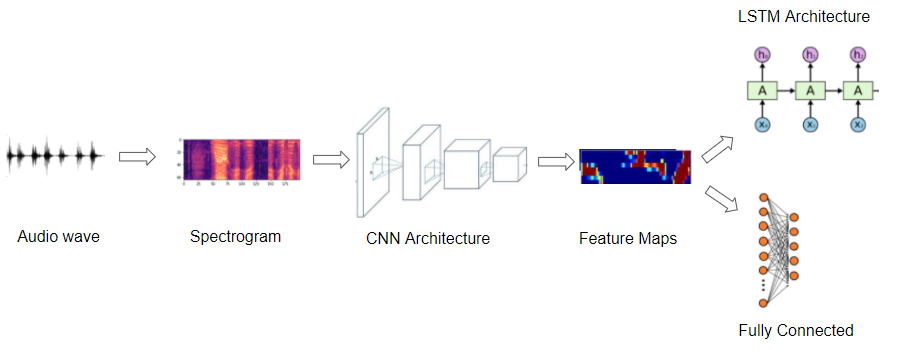

Steps:
1. Audio classification
2. Audio seperation and segmentation
3. Emotion classification and tagging
4. Speech to text and text to speech

Reference:
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

In [3]:
!pip install torchaudio librosa boto3

     |████████████████████████████████| 2.9 MB 101 kB/s ta 0:00:012
  Using cached torch-1.11.0-cp38-cp38-manylinux1_x86_64.whl (750.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.8.2 requires torch==1.7.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.9.0 requires torch==1.8.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.2.0 requires torch<1.9.0,>=1.6.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.2.0 requires transformers<4.5,>=4.1, but you have transformers 4.18.0 which is incompatible.
allennlp-models 2.2.0 requires torch<1.9.0,>=1.7.0, but you have torch 1.11.0 which is incompatible.


In [19]:
# Emotions: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# 03(modality)-01(vocal_channel)-01(emotions_id)-01(emotion_intensity)-01(statement_type)-01(repitition)-01(Actor_id).wav => represents
# Modality: 01 = full-AV, 02 = video-only, 03 = audio-only
# vocal_channel: 01 = speech, 02 = song
# emotions_id: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# emotion_intensity: 01 = normal, 02 = strong
# statement_type: 01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"
# repitition: 01 = 1st repetition, 02 = 2nd repetition
# Actor_id: 01 to 24. Odd numbered actors are male, even numbered actors are female
!ls ./data/

Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24


Import Libraries
=======================

In [162]:
import pandas as pd
import numpy as np

import torch
import torchaudio
import librosa
import librosa.display as display

import sys
import os

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Dataset loading
=============

In [145]:
# https://www.kaggle.com/code/ejlok1/audio-emotion-part-1-explore-data
# https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html
class DataLoading:
    def __init__(self, path="./data/", ):
        self.path = path
    def load_list(self):
        filepath = os.listdir(self.path)
        filepath.sort()
        emotion = []
        gender = []
        path = []
        for fp in filepath:
            file_name = os.listdir(self.path+fp)
            for file in file_name:
                sound_file = file.split(".")[0].split("-")
                emotion.append(int(sound_file[2]))
                actor_id = int(sound_file[-1])
                even_odd = lambda x: "female" if x%2 == 0 else "male"
                gender.append(even_odd(actor_id))
                path.append(self.path+fp+"/"+file)
        return emotion, gender, path

# https://docs.microsoft.com/en-us/learn/modules/intro-audio-classification-pytorch/3-visualizations-transforms
class Audio_preprocess:
    def __init__(self):
        pass
    
    def read_plot_soundwave(self, path):
        filename = path
        #to read sound file
        waveform, sample_rate = torchaudio.load(filename, num_frames=-1)
        #to plot the soundwave
        plt.plot(waveform.t().numpy())
        plt.show()
        return waveform, sample_rate
    
    def show_waveform(self, waveform, sample_rate, label):
        resample_rate = sample_rate/10
        channel = 0
        transform_waveform = torchaudio.transforms.Resample(sample_rate, resample_rate, resampling_method="sinc_interpolation")(waveform[channel,:].view(1, -1))
        plt.plot(transform_waveform[0,:].numpy())
        return transform_waveform, resample_rate
    
    def show_spectrogram(self, waveform, label):
        spectogram = torchaudio.transforms.Spectrogram()(waveform)
        #print(spectogram.shape)
        plt.title(f"Spectogram for {label}")
        plt.imshow(spectogram.log2()[0,:,:].numpy())
        return spectogram
    
    def show_melspectrogram(self, waveform, sample_rate, label):
        mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
        print(mel_spec.size())
        plt.title(f"Spectogram for {label}")
        plt.imshow(mel_spec.log2()[0,:,:].numpy())
        return mel_spec
    
    def show_mfcc(self, waveform, sample_rate, label):
        mfcc_spec = torchaudio.transforms.MFCC(sample_rate)(waveform)
        print(mfcc_spec.size())
        
        plt.title(f"Spectogram for {label}")
        plt.plot(mfcc_spec.log2()[0,:,:].numpy())
        plt.show()
        return mfcc_spec

In [44]:
dl = DataLoading()
emotion, gender, path = dl.load_list()

In [50]:
emotion_df = pd.DataFrame({"emotion": emotion, "gender":gender, "path":path})
emotion_df.head()

,emotion,gender,path
0,7,male,./data/Actor_01/03-01-07-02-02-02-01.wav
1,2,male,./data/Actor_01/03-01-02-01-01-01-01.wav
2,7,male,./data/Actor_01/03-01-07-01-01-01-01.wav
3,5,male,./data/Actor_01/03-01-05-01-01-02-01.wav
4,8,male,./data/Actor_01/03-01-08-02-02-02-01.wav


In [52]:
emotion_df["emotion"].replace({1:"neutral", 2:"calm", 3:"happy", 4:"sad", 5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"}, inplace=True)
emotion_df["labels"] = emotion_df["gender"]+"_"+emotion_df["emotion"]
emotion_df.head()

,emotion,gender,path,labels
0,disgust,male,./data/Actor_01/03-01-07-02-02-02-01.wav,male_disgust
1,calm,male,./data/Actor_01/03-01-02-01-01-01-01.wav,male_calm
2,disgust,male,./data/Actor_01/03-01-07-01-01-01-01.wav,male_disgust
3,angry,male,./data/Actor_01/03-01-05-01-01-02-01.wav,male_angry
4,surprised,male,./data/Actor_01/03-01-08-02-02-02-01.wav,male_surprised


In [56]:
print(emotion_df.nunique(), "\n\nEmotion_Label_Counts\n", emotion_df.labels.value_counts())

emotion       8
gender        2
path       1440
labels       16
dtype: int64 

Emotion_Label_Counts
 male_disgust        96
male_calm           96
male_angry          96
male_surprised      96
male_sad            96
male_happy          96
male_fearful        96
female_angry        96
female_disgust      96
female_sad          96
female_surprised    96
female_happy        96
female_fearful      96
female_calm         96
male_neutral        48
female_neutral      48
Name: labels, dtype: int64


Data Processing
===========================

In [154]:
wf, sr = librosa.load(emotion_df["path"].iloc[-1], sr=None)
print(wf, sr)

[0. 0. 0. ... 0. 0. 0.] 48000


In [156]:
tempo, beat_frames = librosa.beat.beat_track(wf, sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

Estimated tempo: 152.03 beats per minute


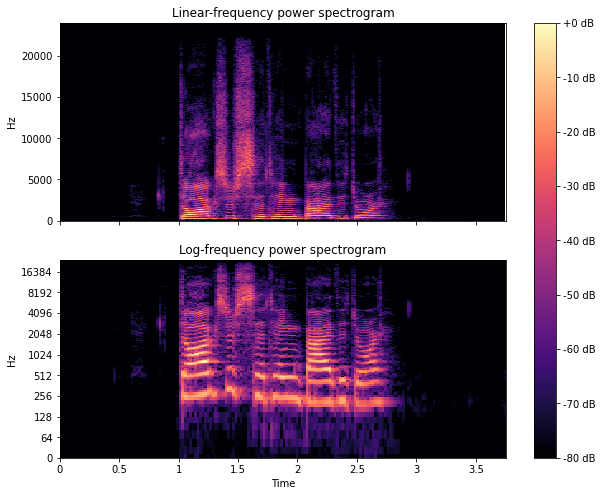

In [171]:
y = wf

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(10,8))
# plt.figure(figsize=(10,20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached

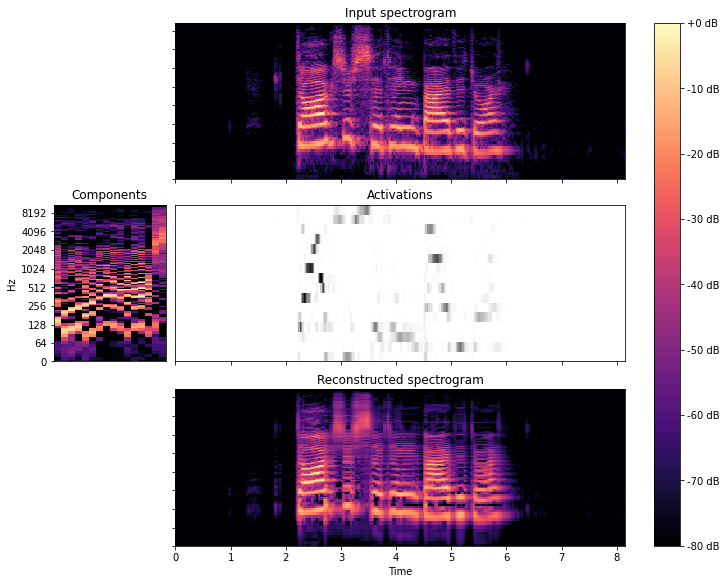

In [173]:
import sklearn.decomposition

S = np.abs(librosa.stft(y))
comps, acts = librosa.decompose.decompose(S, n_components=16)

comps, acts = librosa.decompose.decompose(S, n_components=16,
                                          sort=True)

layout = [list(".AAAA"), list("BCCCC"), list(".DDDD")]
fig, ax = plt.subplot_mosaic(layout, constrained_layout=True,figsize=(10,8))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax['A'])
ax['A'].set(title='Input spectrogram')
ax['A'].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(comps,
                                                 ref=np.max),
                         y_axis='log', ax=ax['B'])

ax['B'].set(title='Components')
ax['B'].label_outer()
ax['B'].sharey(ax['A'])
librosa.display.specshow(acts, x_axis='time', ax=ax['C'], cmap='gray_r')

ax['C'].set(ylabel='Components', title='Activations')
ax['C'].sharex(ax['A'])
ax['C'].label_outer()

S_approx = comps.dot(acts)
img = librosa.display.specshow(librosa.amplitude_to_db(S_approx,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax['D'])

ax['D'].set(title='Reconstructed spectrogram')
ax['D'].sharex(ax['A'])
ax['D'].sharey(ax['A'])
ax['D'].label_outer()
fig.colorbar(img, ax=list(ax.values()), format="%+2.f dB")

In [235]:
# cross similarity
# https://librosa.org/doc/latest/generated/librosa.segment.cross_similarity.html#librosa.segment.cross_similarity
hop_length = 1024
path1 = emotion_df["path"].iloc[2]
label1 = emotion_df["labels"].iloc[2]

path2 = emotion_df["path"].iloc[3]
label2 = emotion_df["labels"].iloc[3]

y_ref, sr1 = librosa.load(path1)
y_comp, sr2 = librosa.load(path2)

print(label1, label2)
chroma_ref = librosa.feature.chroma_cqt(y=y_ref, sr=sr1, hop_length=hop_length)
chroma_comp = librosa.feature.chroma_cqt(y=y_comp, sr=sr2, hop_length=hop_length)

# Use time-delay embedding to get a cleaner recurrence matrix
x_ref = librosa.feature.stack_memory(chroma_ref, n_steps=10, delay=3)
x_comp = librosa.feature.stack_memory(chroma_comp, n_steps=10, delay=3)
xsim = librosa.segment.cross_similarity(x_comp, x_ref)

male_disgust male_angry


In [220]:
ipd.Audio(y_ref, rate=sr1)

In [221]:
ipd.Audio(y_comp, rate=sr2)

In [250]:
xsim_knn = librosa.segment.cross_similarity(x_comp, x_ref, k=8)
print(xsim_knn)

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ...  True False  True]
 [False False False ...  True  True  True]
 [False False False ... False  True  True]]


In [251]:
xsim_aff_knn = librosa.segment.cross_similarity(x_comp, x_ref, metric='euclidean', mode='affinity')
print(xsim_aff_knn)

[[0.71564007 0.73610055 0.71879387 ... 0.         0.         0.        ]
 [0.73227537 0.7484558  0.7362609  ... 0.         0.         0.        ]
 [0.7558634  0.7649008  0.7592624  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.46320218 0.43076292 0.44880503]
 [0.         0.         0.         ... 0.43134555 0.46917206 0.46429858]
 [0.         0.         0.         ... 0.38684103 0.46535298 0.45055312]]


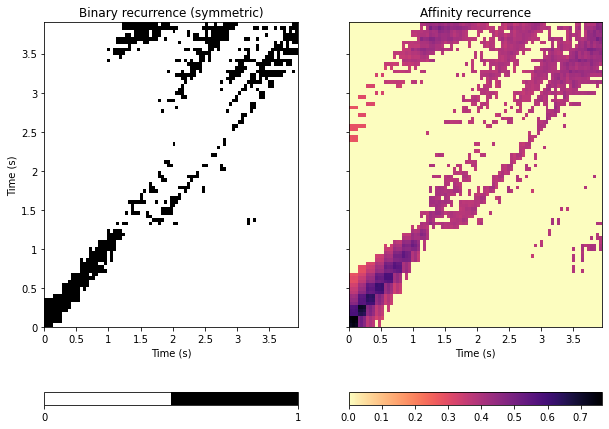

In [252]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(10,8))
imgsim = librosa.display.specshow(xsim_knn, x_axis='s', y_axis='s',
                         hop_length=hop_length, ax=ax[0])
ax[0].set(title='Binary recurrence (symmetric)')
imgaff = librosa.display.specshow(xsim_aff_knn, x_axis='s', y_axis='s',
                         cmap='magma_r', hop_length=hop_length, ax=ax[1])
ax[1].set(title='Affinity recurrence')
ax[1].label_outer()
fig.colorbar(imgsim, ax=ax[0], orientation='horizontal', ticks=[0, 1])
fig.colorbar(imgaff, ax=ax[1], orientation='horizontal')

In [253]:
xsim_cosine = librosa.segment.cross_similarity(x_comp, x_ref, metric='cosine')
print(xsim_cosine)

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ... False  True  True]]


In [254]:
xsim_aff_cosine = librosa.segment.cross_similarity(x_comp, x_ref, metric='cosine', mode='affinity')
print(xsim_aff)

[[0.         0.9180286  0.83178914 ... 0.         0.         0.        ]
 [0.9180286  0.         0.9706473  ... 0.         0.         0.        ]
 [0.83178914 0.9706473  0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999917 0.95214474 0.817963  ]
 [0.         0.         0.         ... 0.95214504 0.         0.88321817]
 [0.         0.         0.         ... 0.817963   0.88321817 0.        ]]


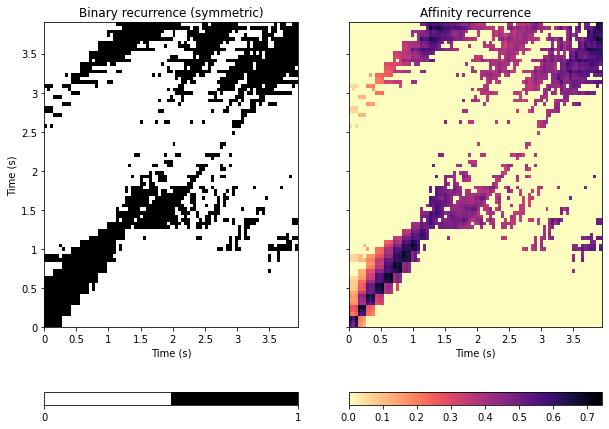

In [255]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(10,8))
imgsim = librosa.display.specshow(xsim_cosine, x_axis='s', y_axis='s',
                         hop_length=hop_length, ax=ax[0])
ax[0].set(title='Binary recurrence (symmetric)')
imgaff = librosa.display.specshow(xsim_aff_cosine, x_axis='s', y_axis='s',
                         cmap='magma_r', hop_length=hop_length, ax=ax[1])
ax[1].set(title='Affinity recurrence')
ax[1].label_outer()
fig.colorbar(imgsim, ax=ax[0], orientation='horizontal', ticks=[0, 1])
fig.colorbar(imgaff, ax=ax[1], orientation='horizontal')

In [256]:
hop_length = 1024
y_ref, sr = librosa.load(path1)
y_comp, sr = librosa.load(path2)
chroma_ref = librosa.feature.chroma_cqt(y=y_ref, 
  sr=sr,hop_length=hop_length)
chroma_comp = librosa.feature.chroma_cqt(y=y_comp, 
  sr=sr, hop_length=hop_length)

x_ref = librosa.feature.stack_memory(
  chroma_ref, n_steps=10, delay=3)
x_comp = librosa.feature.stack_memory(
  chroma_comp, n_steps=10, delay=3)
xsim = librosa.segment.cross_similarity(x_comp, x_ref)

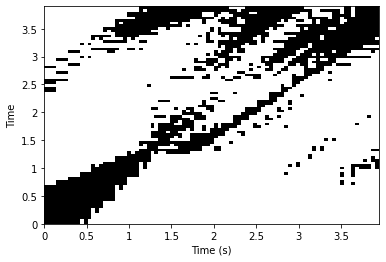

In [257]:
fig, ax = plt.subplots()

librosa.display.specshow(xsim, x_axis='s', y_axis='time', hop_length=hop_length, ax=ax)
plt.show()

In [146]:
# initialising audio processing class
audio_cls = Audio_preprocess()

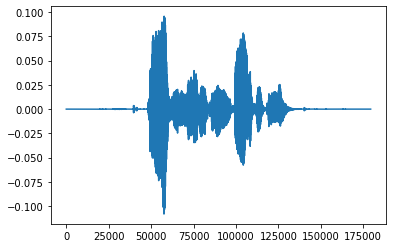

In [93]:
waveform, sample_rate = audio_cls.read_plot_soundwave(emotion_df["path"].iloc[-1])
#to play sound
ipd.Audio(waveform.numpy(), rate=sample_rate)

Current_emotion:  female_happy : 
Waveform: tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), Sample_rate: 48000
Transformed waveform: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0492e-05, 4.1557e-05,
         2.5711e-05]]), Resample rate: 4800.0


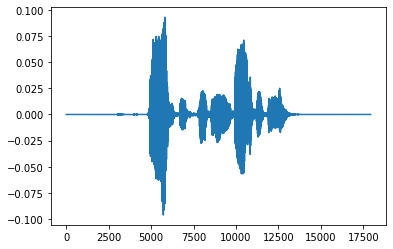

In [94]:
print("Current_emotion: ",emotion_df["labels"].iloc[-1],f": \nWaveform: {waveform}, Sample_rate: {sample_rate}")
transform_waveform, resample_rate = audio_cls.show_waveform(waveform, sample_rate, emotion_df["labels"].iloc[-1])
print(f"Transformed waveform: {transform_waveform}, Resample rate: {resample_rate}")

Current_emotion:  female_happy : 
Waveform: tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), Sample_rate: 48000
Transformed waveform: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0520e-05, 4.1533e-05,
         2.5684e-05]]), Resample rate: 4800.0


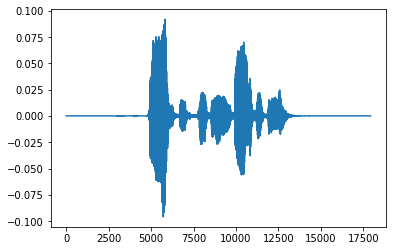

In [97]:
print("Current_emotion: ",emotion_df["labels"].iloc[-1],f": \nWaveform: {waveform}, Sample_rate: {sample_rate}")
transform_waveform, resample_rate = audio_cls.show_waveform(waveform, sample_rate, emotion_df["labels"].iloc[-1])
print(f"Transformed waveform: {transform_waveform}, Resample rate: {resample_rate}")

In [98]:
# The audio is little less loud in comparison to withour resampling
ipd.Audio(transform_waveform.numpy(), rate=resample_rate)

torch.Size([1, 201, 897])
torch.Size([1, 201, 897])


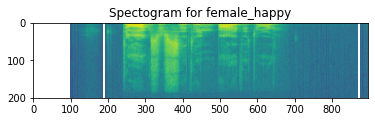

In [129]:
spectogram = audio_cls.show_spectogram(waveform, emotion_df["labels"].iloc[-1])
print(spectogram.shape)

torch.Size([1, 201, 90])


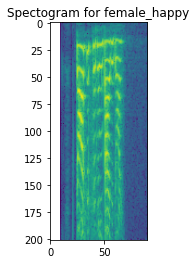

In [109]:
tr_spectogram = audio_cls.show_spectogram(transform_waveform, emotion_df["labels"].iloc[-1])
print(tr_spectogram.shape)

Current_emotion:  female_happy : 
Waveform: tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), Sample_rate: 48000
torch.Size([1, 128, 897])
Mel Spectogram: tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9044e-08,
          7.0062e-08, 1.3095e-07],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8582e-08,
          4.7152e-08, 7.1470e-08],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4461e-08,
          8.5656e-08, 1.3484e-07]]]), Size: torch.Size([1, 128, 897])


/opt/conda/lib/python3.8/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


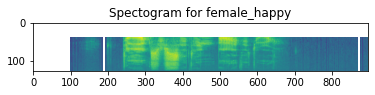

In [134]:
print("Current_emotion: ",emotion_df["labels"].iloc[-1],f": \nWaveform: {waveform}, Sample_rate: {sample_rate}")
mel_spec = audio_cls.show_melspectrogram(waveform, sample_rate, emotion_df["labels"].iloc[-1])
print(f"Mel Spectogram: {mel_spec}, Size: {mel_spec.size()}")

Current_emotion:  female_happy : 
Waveform: tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), Sample_rate: 48000
torch.Size([1, 40, 897])


/opt/conda/lib/python3.8/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


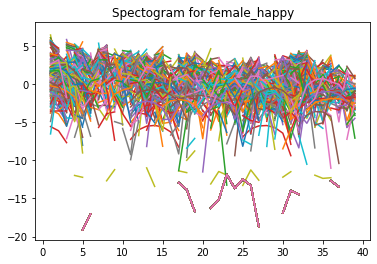

Mfcc Spectogram: tensor([[[-7.9082e+02, -7.9082e+02, -7.9082e+02,  ..., -7.9045e+02,
          -7.8988e+02, -7.7716e+02],
         [-8.3088e-06, -8.3088e-06, -8.3088e-06,  ...,  4.7018e-01,
           1.1522e+00,  6.0428e+00],
         [-2.4418e-05, -2.4418e-05, -2.4418e-05,  ...,  3.1969e-01,
           7.9125e-01,  9.1015e+00],
         ...,
         [ 8.7261e-05,  8.7261e-05,  8.7261e-05,  ...,  3.8813e-01,
          -3.1853e-01, -7.1046e-01],
         [-2.2347e-04, -2.2347e-04, -2.2347e-04,  ...,  2.0387e-01,
           8.7580e-02, -2.2003e+00],
         [-1.9646e-04, -1.9646e-04, -1.9646e-04,  ..., -1.4915e-02,
           5.3497e-01, -3.0293e+00]]]), Size: torch.Size([1, 40, 897])


In [147]:
print("Current_emotion: ",emotion_df["labels"].iloc[-1],f": \nWaveform: {waveform}, Sample_rate: {sample_rate}")
mfcc_spec = audio_cls.show_mfcc(waveform, sample_rate, emotion_df["labels"].iloc[-1])
print(f"Mfcc Spectogram: {mfcc_spec}, Size: {mfcc_spec.size()}")